<img src = "../../Data/bgsedsc_0.jpg">

# Extended Project: KNN project

The aim of this project is to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit). The dataset comes from MIMIC project (https://mimic.physionet.org/) which refers to the Medical Information Mart for Intensive Care. The preprocessing of the data is the same for both the KNN and SVM projects, with the difference that SVM tackle class imbalance.

## Modules and auxiliar functions import

The relevant modules are loaded and the auxiliar functions from *helper_functions* are imported. It is also set a random seed to ensure reproducibility and it is checked the current working directory.

In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from utils.helper_functions import *

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import ipywidgets

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder
from dateutil.relativedelta import relativedelta
from scipy.stats import skew
from collections import Counter
from imblearn.under_sampling import AllKNN

import warnings
warnings.filterwarnings('ignore')

np.random.seed(3123)

!pwd

/Users/bertacanal/Desktop


## Data load

The **training dataset** is imported as a pandas DataFrame and the first 5 rows are displayed to get an overview of the structure and the contents. The dataset consists of 20885 observations and 44 columns.

In [2]:
import pandas as pd

data=pd.read_csv('/Users/bertacanal/Desktop/cml23-probability-of-death-with-k-nn/mimic_train.csv')
print(data.shape)
data.head()

(20885, 44)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


The **test dataset** is imported as a pandas DataFrame and the first 5 rows are displayed to get an overview of the structure and the contents. This dataset will be used to produce predictions and consists of 5221 observations and 39 columns. This dataset does not include the variable *'HOSPITAL_EXPIRE_FLAG'*, therefore, a copy of this dataset is renamed as *X_test*.

In [3]:
data_test=pd.read_csv('/Users/bertacanal/Desktop/cml23-probability-of-death-with-k-nn/mimic_test_death.csv')
X_test = data_test.copy()
print(X_test.shape)
X_test.sort_values('icustay_id').head()

(5221, 39)


,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,...,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,...,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,...,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,...,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


# Preprocessing of the data

## Exploration of the dataset

Each observation of the training dataset correspond to the ICU stay of a patient. The outcome to predict is the column HOSPITAL_EXPIRE_FLAG, which indicates if the patient died during the current hospital stay (= 1) or survived (= 0). There are ID columns related to the ICU stay (*hadm_id* and *icustay_id*) and to the patient (*subject_id*). Other columns refer to the vitals of the patient (when entering the ICU) and general information. The specific meaning of each feature is specified in the table below (extracted from the file *mimic_patient_metadata.xlsx*). 

In [4]:
meaning=pd.read_excel('/Users/bertacanal/Desktop/cml23-probability-of-death-with-k-nn/mimic_patient_metadata.xlsx', header = 4)
pd.set_option('display.max_colwidth', None)
meaning

,Field,Description
0,HOSPITAL_EXPIRE_FLAG,1 if patient died during this hospital stay
1,subject_id,Patient identifier
2,hadm_id,Hospital stay identifier
3,icustay_id,ICU stay identifier
4,HeartRate_Min,Heart Rate
5,HeartRate_Max,Heart Rate
6,HeartRate_Mean,Heart Rate
7,SysBP_Min,Systolic Blood Pressure
8,SysBP_Max,Systolic Blood Pressure
9,SysBP_Mean,Systolic Blood Pressure


The following bar plot represents the distribution of the *'HOSPITAL_EXPIRE_FLAG'* variable, showing the counts of *Survived* and *Not Survived* categories.

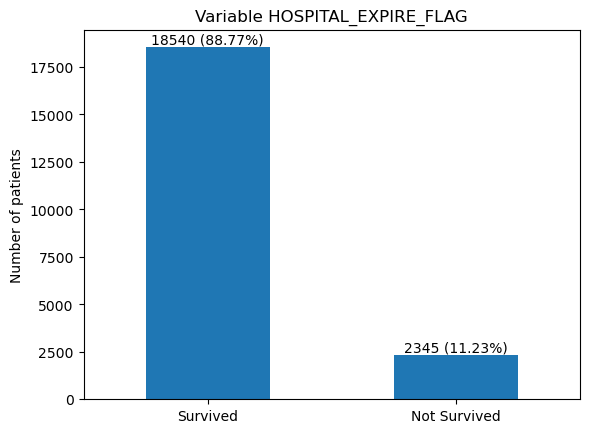

In [5]:
labels = {0: 'Survived', 1: 'Not Survived'}
value_counts = data['HOSPITAL_EXPIRE_FLAG'].map(labels).value_counts()

total_patients = value_counts.sum()
plot = value_counts.plot(kind='bar', rot=0)

for index, value in enumerate(value_counts):
    percentage = (value / total_patients) * 100
    plt.text(index, value, f"{value} ({percentage:.2f}%)", ha='center', va='bottom')

plt.ylabel('Number of patients')
plt.title('Variable HOSPITAL_EXPIRE_FLAG')

plt.show()

## Addition of metadata

As shown in the description of the variables, the *ICD9_diagnosis* column includes the main cause/disease of patient condition. However, a patient can have co-ocurrent diseases (comorbodities). The file containing the secondary codes is *MIMIC_diagnoses.csv* and some merge is required to consider these additional diagnoses. It is assumed that all of the comorbidities were diagnosed on the first day of the patient in the ICU.

In [6]:
MIMIC_diagnoses = pd.read_csv('/Users/bertacanal/Desktop/cml23-probability-of-death-with-k-nn/extra_data/MIMIC_diagnoses.csv')
MIMIC_diagnoses.rename(columns={'HADM_ID': 'hadm_id'}, inplace=True)
MIMIC_diagnoses.head()

,SUBJECT_ID,hadm_id,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


A reasonable threshold of diagnoses to consider for the project is set to 20, but given that the training dataset already includes the main one, the merge will only include those ICD9_CODES assigned to SEQ_NUM from 2 to 20. For the missing data it is created a missing class called *MISSING_DIAGNOSIS*. Both dataframes are join on 'hadm_id' (which refers to the hospital stay identifier) because the *MIMIC_diagnoses.csv* includes information about different hospital stays of the different of each patients.

In [7]:
for seq_num in range (2, 21):
    secondary_codes = MIMIC_diagnoses[MIMIC_diagnoses['SEQ_NUM'] == seq_num].copy()
    secondary_codes.head()

    secondary_codes[f'ICD9_CODE_{seq_num}'] = secondary_codes['ICD9_CODE']
    secondary_codes.head()
    data = pd.merge(data,secondary_codes[['hadm_id',f'ICD9_CODE_{seq_num}']],on='hadm_id', how='left')
    data[f'ICD9_CODE_{seq_num}'].fillna('MISSING_DIAGNOSIS', inplace = True)
    X_test = pd.merge(X_test,secondary_codes[['hadm_id',f'ICD9_CODE_{seq_num}']],on='hadm_id', how='left')
    X_test[f'ICD9_CODE_{seq_num}'].fillna('MISSING_DIAGNOSIS', inplace = True)
    
data.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,ICD9_CODE_11,ICD9_CODE_12,ICD9_CODE_13,ICD9_CODE_14,ICD9_CODE_15,ICD9_CODE_16,ICD9_CODE_17,ICD9_CODE_18,ICD9_CODE_19,ICD9_CODE_20
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,42789,49320,40390,5852,43811,43889,78079,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,40390,25002,5859,4465,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,311,V1082,V1351,V4364,V4365,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,E8788,42731,4280,496,2449,V1011,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS


In [8]:
proportions = []

for seq_num in range (2, 21):
    column_name = f'ICD9_CODE_{seq_num}'
    if column_name in data.columns:
        counts = data[column_name].value_counts()
        if 'MISSING_DIAGNOSIS' in counts:
            proportion = round((counts['MISSING_DIAGNOSIS'] / data.shape[0])*100,2)
            proportions.append((column_name, proportion))
proportions_df = pd.DataFrame(proportions, columns=['Column Name', 'Proportion of "MISSING_DIAGNOSIS" (%)'])
proportions_df

,Column Name,"Proportion of ""MISSING_DIAGNOSIS"" (%)"
0,ICD9_CODE_2,0.24
1,ICD9_CODE_3,0.88
2,ICD9_CODE_4,2.12
3,ICD9_CODE_5,4.24
4,ICD9_CODE_6,7.12
5,ICD9_CODE_7,10.68
6,ICD9_CODE_8,15.02
7,ICD9_CODE_9,19.79
8,ICD9_CODE_10,25.15
9,ICD9_CODE_11,30.85


Since the proportion of missing data for those columns referring to a higher sequence number is high, it seems reasonable to drop some of those columns. Therefore, this project will set as threshold a proportion of 40% of missing data for the secondary codes and thus only consider until the column referring to the sequence number 12.

In [9]:
data = data.drop(['ICD9_CODE_13', 'ICD9_CODE_14', 'ICD9_CODE_15', 'ICD9_CODE_16', 'ICD9_CODE_17', 'ICD9_CODE_18', 'ICD9_CODE_19', 'ICD9_CODE_20'], axis=1)
X_test = X_test.drop(['ICD9_CODE_13', 'ICD9_CODE_14', 'ICD9_CODE_15', 'ICD9_CODE_16', 'ICD9_CODE_17', 'ICD9_CODE_18', 'ICD9_CODE_19', 'ICD9_CODE_20'], axis=1)

## Dicernment between *X_train* and *y_train*

From the training dataset it should be distinguished between *X_train* (including all the features) and *y_train* (including the variable *HOSPITAL_EXPIRE_FLAG*).

In [10]:
X_train = data.drop(['HOSPITAL_EXPIRE_FLAG'], axis=1)
y_train = data['HOSPITAL_EXPIRE_FLAG']

X_train.head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ICD9_CODE_3,ICD9_CODE_4,ICD9_CODE_5,ICD9_CODE_6,ICD9_CODE_7,ICD9_CODE_8,ICD9_CODE_9,ICD9_CODE_10,ICD9_CODE_11,ICD9_CODE_12
0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,...,41071,42831,42732,2851,53550,79092,4280,42731,42789,49320
1,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,...,E915,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS
2,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,...,5845,5789,5121,5119,56889,E8788,3310,29410,40390,25002
3,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,...,5163,4280,53081,73300,2720,4019,2440,30000,311,V1082
4,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9973,5180,9341,99859,6822,9971,42732,42832,E8788,42731


The following code aims to compare the dimensions from *X_train* and *X_test*. As expected, the number of observations of the training dataset is higher than the testing dataset since we want to feed the model with as much data as possible to find and learn meaningful patterns.

In [11]:
dimensions = [X_train.shape, X_test.shape]
dimensions_df = pd.DataFrame([(int(dim[0]), int(dim[1])) for dim in dimensions], index= ["X_train", "X_test"], columns=["Rows", "Columns"])
dimensions_df

,Rows,Columns
X_train,20885,54
X_test,5221,50


To know which columns appear in *X_train* but not in *X_test* it is done a set difference operation. It is useful to know the columns in each dataset for the step related to drop the features not used in the model. As seen in the output, the columns that only appear in *X_train* correspond to *'DEATHTIME'*, *'DISCHTIME'*, *'DOD'* and *'LOS'*.

In [12]:
columns_X_train = set(X_train.columns)
columns_X_test = set(X_test.columns)

columns_only_in_X_train = columns_X_train - columns_X_test
columns_only_in_X_train

{'DEATHTIME', 'DISCHTIME', 'DOD', 'LOS'}

## Creation of the *AGE* variable

The age could have an impact on the probability of death of a patient that is entering an ICU, however, there is no specific feature in the dataset referring to the age. An alternative could be to subtract the *DOB* (Date of Birth) from the *DOD* (Date of Death) but it has to be disregarded since the *DOD* is not known in the first day of a patient in an ICU and moreover it does not allow to compute the age of the patients who survive.

Therefore, the procedure followed consists on subtracting the *DOB* (Date of Birth) from the *ADMITTIME* (Admision datetime) since this results on the age of the patient in the admission day. These two date columns are converted to datatime objects and then the age is computed using the *relativedelta* function.

#### In the training dataset

In [13]:
X_train['DOB'] = pd.to_datetime(X_train['DOB'], format='%Y-%m-%d %H:%M:%S')
X_train['ADMITTIME'] = pd.to_datetime(X_train['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')

X_train['AGE'] = X_train.apply(lambda row: relativedelta(row['ADMITTIME'], row['DOB']).years, axis=1)

X_train['AGE'].describe()

count    20885.000000
mean        74.884606
std         55.755731
min         15.000000
25%         53.000000
50%         65.000000
75%         78.000000
max        310.000000
Name: AGE, dtype: float64

#### In the testing dataset

In [14]:
X_test['DOB'] = pd.to_datetime(X_test['DOB'], format='%Y-%m-%d %H:%M:%S')
X_test['ADMITTIME'] = pd.to_datetime(X_test['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')

X_test['AGE'] = X_test.apply(lambda row: relativedelta(row['ADMITTIME'], row['DOB']).years, axis=1)

X_test['AGE'].describe()

count    5221.000000
mean       75.090021
std        54.973065
min        15.000000
25%        53.000000
50%        66.000000
75%        78.000000
max       310.000000
Name: AGE, dtype: float64

#### Adjustments to the variable *AGE*

The quartiles and the mean seem to be reasonable. However, since the maximum value of the column *AGE* corresponds to 310 in both the training and testing data, an adjustment is needed.  The problem is that the age of patients older than 89 has been fixed to 300 at their first admission (Source: https://mimic.mit.edu/docs/iii/about/time/). 

In [15]:
print('Patients older than 89:')
print(X_train[X_train['AGE'] > 89]['AGE'])

Patients older than 89:
10       300
13       300
30       300
53       300
56       300
        ... 
20837    300
20844    300
20853    300
20874    300
20883    300
Name: AGE, Length: 1107, dtype: int64


Therefore, it is reasonable to readjust the *AGE* by assigning 89 years as the maximum patient's age:

In [16]:
X_train['AGE'] = X_train['AGE'].apply(lambda age: min(age, 89))
X_test['AGE'] = X_test['AGE'].apply(lambda age: min(age, 89))

## Features selection

Vital signs are considered important in medical care and disease diagnosis. They include heart rate, blood pressure, respiratory rate and body temperature. For example, a significant increase or decrease in heart rate may be an indicator of heart problems, high blood pressure can increase the risk of cardiovascular diseases, changes in respiratory rate can indicate respiratory or cardiovascular problems and a significant increase or decrease in temperature can be a sign of infection. Therefore, features related to the minimum, maximum and mean of the vital signs are included in the model.

Both the main disease and comorbidities play significant roles in determining a patient's probability of death. The main disease's severity directly influences the risk of mortality. Comorbidities, on the other hand, add complexity to the patient's health profile: they can complicate treatment, reduce the body's ability to respond to stress and weaken the immune system. Therefore, features related to the main disease and comorbodities are included in the model.

Both gender and age can impact a patient's probability of survival in the ICU. Gender can influence because of differences in biological, hormonal, and treatment responses and age affects physiological reserves and vulnerability to illness.

Patients admitted to the ICU in an emergency, such as after a sudden cardiac arrest or trauma, may have a higher initial severity of illness. This can increase the risk of mortality, therefore it seems reasonable that admission type infers on the probability of death. The first care unit to which a patient is assigned can provide valuable insights into the initial assessment of the patient's condition and potential factors that may influence their probability of death. At the same time, the type of insurance also infers because it affects the access to care and the care quality, since patients with certain insurance plans may receive care at facilities with higher ICU quality ratings, potentially leading to better outcomes. Marital status can also be an influenting factor through factors such as social support, advocacy and emotional well-being. For example, married patients may benefit from spousal support or better mental health. 

In many healthcare systems, medical care and treatment standards are designed to be uniform and evidence-based, focusing on clinical needs rather than ethnic or religious considerations. Therefore, ethnicity and religion are not included in the model. ID variables are also excluded since these are not predictive of death and add noise into the model, thus decreasing its performance. 

#### From the training dataset

The features not included in the model are dropped. From the training dataset we exclude the ID variables (*subject_id*, *hadm_id* and *icustay_id*), the features we don't know the first day of a patient in an ICU (*DOD*, *DISCHTIME*, *DEATHTIME* and *LOS*) and the variables we consider not to infer in the probability of death of a patient (*ETHNICITY*, *RELIGION* and *Diff*). In addition, the variables used to create the *AGE* variable, in particular *DOB* and *ADMITTIME*, are also excluded since its information is already contained by the model with the created *AGE* variable.

In [17]:
X_train = X_train.drop(['subject_id', 'hadm_id', 'icustay_id', 'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'Diff', 'LOS', 'ETHNICITY', 'RELIGION'], axis=1)
print(X_train.shape)
X_train.head()

(20885, 43)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,ICD9_CODE_4,ICD9_CODE_5,ICD9_CODE_6,ICD9_CODE_7,ICD9_CODE_8,ICD9_CODE_9,ICD9_CODE_10,ICD9_CODE_11,ICD9_CODE_12,AGE
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,...,42831,42732,2851,53550,79092,4280,42731,42789,49320,69
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,...,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,42
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,...,5789,5121,5119,56889,E8788,3310,29410,40390,25002,68
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,...,4280,53081,73300,2720,4019,2440,30000,311,V1082,74
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5180,9341,99859,6822,9971,42732,42832,E8788,42731,79


#### From the testing dataset

The features not included in the model are dropped. From the testing dataset we exclude the ID variables (*subject_id*, *hadm_id* and *icustay_id*) and the variables we consider not to infer in the probability of death of a patient (*ETHNICITY*, *RELIGION* and *Diff*). In addition, the variables used to create the *AGE* variable, in particular *DOB* and *ADMITTIME*, are also excluded since its information is already contained by the model with the created *AGE* variable.

As seen before, *X_test* does not contain the columns *'DEATHTIME'*, *'DISCHTIME'*, *'DOD'* and *'LOS'*. Therefore, these columns should not be droped from the testing dataset.

In [18]:
X_test = X_test.drop(['subject_id', 'hadm_id', 'icustay_id', 'DOB','ADMITTIME', 'Diff', 'ETHNICITY', 'RELIGION'], axis=1)
print(X_test.shape)
X_test.head()

(5221, 43)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,ICD9_CODE_4,ICD9_CODE_5,ICD9_CODE_6,ICD9_CODE_7,ICD9_CODE_8,ICD9_CODE_9,ICD9_CODE_10,ICD9_CODE_11,ICD9_CODE_12,AGE
0,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,77.0,52.018182,53.0,...,2851,99702,E8782,41401,45829,42731,3682,3659,9916,81
1,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,86.0,65.578947,50.0,...,5845,4820,2760,4019,70703,70725,42789,V5867,MISSING_DIAGNOSIS,48
2,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,76.0,66.703704,60.0,...,99591,2869,99859,99811,340,59654,04185,27650,E8788,42
3,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,99.0,62.854545,46.0,...,5180,2851,73313,4280,E8843,45829,41401,4019,2724,84
4,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,133.0,72.833333,66.0,...,75989,49121,42832,2639,99799,4168,42731,V462,41400,52


After dropping the variables, it can be observed that the number of columns on both *X_train* and *X_test* is equal:

In [19]:
dimensions = [X_train.shape, X_test.shape]
dimensions_df = pd.DataFrame([(int(dim[0]), int(dim[1])) for dim in dimensions], index= ["X_train", "X_test"], columns=["Rows", "Columns"])
dimensions_df

,Rows,Columns
X_train,20885,43
X_test,5221,43


The following code creates a list of the names of the categorical and numerical columns:

In [20]:
categorical_features_names = ['GENDER', 'INSURANCE', 'ADMISSION_TYPE', 'MARITAL_STATUS', 'FIRST_CAREUNIT', 'ICD9_diagnosis', 'DIAGNOSIS', 'ICD9_CODE_2', 'ICD9_CODE_3', 'ICD9_CODE_4', 'ICD9_CODE_5', 'ICD9_CODE_6', 'ICD9_CODE_7', 'ICD9_CODE_8', 'ICD9_CODE_9', 'ICD9_CODE_10', 'ICD9_CODE_11', 'ICD9_CODE_12']

numerical_features_names = [name for name in X_train.columns if name not in categorical_features_names]

## Cardinality of categorical features

Categorical features will be treated differently depending on the cardinality. The following output provides information about the categorical features: *count* corresponds to the number of non-null values, *unique* indicates the number of unique categories in the feature, *top* refers to the most frequent category and *freq* corresponds to the frequency in which the top category occur.

In [21]:
categorical_summary = []

for feature in categorical_features_names:
    summary = X_train[feature].describe()
    categorical_summary.append(summary)

categorical_summary_table = pd.DataFrame(categorical_summary, index=categorical_features_names)
categorical_summary_table

,count,unique,top,freq
GENDER,20885,2,M,11759
INSURANCE,20885,5,Medicare,11718
ADMISSION_TYPE,20885,3,EMERGENCY,17817
MARITAL_STATUS,20163,7,MARRIED,9664
FIRST_CAREUNIT,20885,5,MICU,8640
ICD9_diagnosis,20885,1853,41401,1098
DIAGNOSIS,20885,6193,PNEUMONIA,876
ICD9_CODE_2,20885,1572,5849,1599
ICD9_CODE_3,20885,1928,5849,840
ICD9_CODE_4,20885,2034,4019,627


As can be seen in the output of the previous code, the low cardinality variables consist on *GENDER*, *INSURANCE*, *ADMISSION_TYPE*, *MARITAL_STATUS* and *FIRST_CAREUNIT* while the variables with high cardinality consists on the *DIAGNOSIS* feature and the variables including ICD9 codes.

The output is also useful to identify that most of the patients from the training dataset are males, the most frequent marital status is to be married, the insurance is Medicare, the admission type is emergency and the first ICU assigned is Medical Intensive Care Unit (MICU). 

Regarding the diagnoses, the most frequent main disease corresponds to *Coronary atherosclerosis of native coronary artery*. The most frequent comorbidities are *Acute kidney failure, unspecified* and *Unspecified essential hypertension*. This later information has been extracted from the file *MIMIC_metadata_diagnose* which includes the meaning of the ICD9 codes.

In [22]:
meaning_diagnoses = pd.read_csv('/Users/bertacanal/Desktop/cml23-probability-of-death-with-k-nn/extra_data/MIMIC_metadata_diagnose.csv')
target_ICD9_CODES = ['41401', '5849', '4019']
meaning_diagnoses[meaning_diagnoses['ICD9_CODE'].isin(target_ICD9_CODES)]

,ICD9_CODE,SHORT_DIAGNOSE,LONG_DIAGNOSE
1053,4019,Hypertension NOS,Unspecified essential hypertension
9457,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
10568,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary artery


## Treatment of the low cardinality categorical features

Focusing on the low cardinality categorical features, let's see more in detail how many observations are included in each category.

In [23]:
pd.DataFrame(X_train['GENDER'].value_counts())

,GENDER
M,11759
F,9126


In [24]:
pd.DataFrame(X_train['FIRST_CAREUNIT'].value_counts())

,FIRST_CAREUNIT
MICU,8640
SICU,3961
CSRU,3127
TSICU,2645
CCU,2512


In [25]:
pd.DataFrame(X_train['INSURANCE'].value_counts())

,INSURANCE
Medicare,11718
Private,6245
Medicaid,2117
Government,611
Self Pay,194


In [26]:
pd.DataFrame(X_train['ADMISSION_TYPE'].value_counts())

,ADMISSION_TYPE
EMERGENCY,17817
ELECTIVE,2848
URGENT,220


In [27]:
pd.DataFrame(X_train['MARITAL_STATUS'].value_counts())

,MARITAL_STATUS
MARRIED,9664
SINGLE,5910
WIDOWED,2819
DIVORCED,1413
SEPARATED,240
UNKNOWN (DEFAULT),103
LIFE PARTNER,14


Given that *MARITAL_STATUS* has categories with a low number of observations, it is reasonable to group the categories that includes less than 5% of the total observations in *X_train*:

In [28]:
marital_status_counts = X_train['MARITAL_STATUS'].value_counts()
categories_to_replace = marital_status_counts[marital_status_counts < 0.05 * len(X_train)].index

X_train.loc[X_train['MARITAL_STATUS'].isin(categories_to_replace), 'MARITAL_STATUS'] = 'OTHER'
X_test.loc[X_test['MARITAL_STATUS'].isin(categories_to_replace), 'MARITAL_STATUS'] = 'OTHER'

As can be seen, this preprocessing step group the categories *'SEPARATED'*, *'UNKNOWN (DEFAULT)'* and *'LIFE PARTNER'* with the category *'OTHERS'*:

In [29]:
pd.DataFrame(X_train['MARITAL_STATUS'].value_counts())

,MARITAL_STATUS
MARRIED,9664
SINGLE,5910
WIDOWED,2819
DIVORCED,1413
OTHER,357


The distribution of the low cardinality categorical features are depicted in the following graphs:

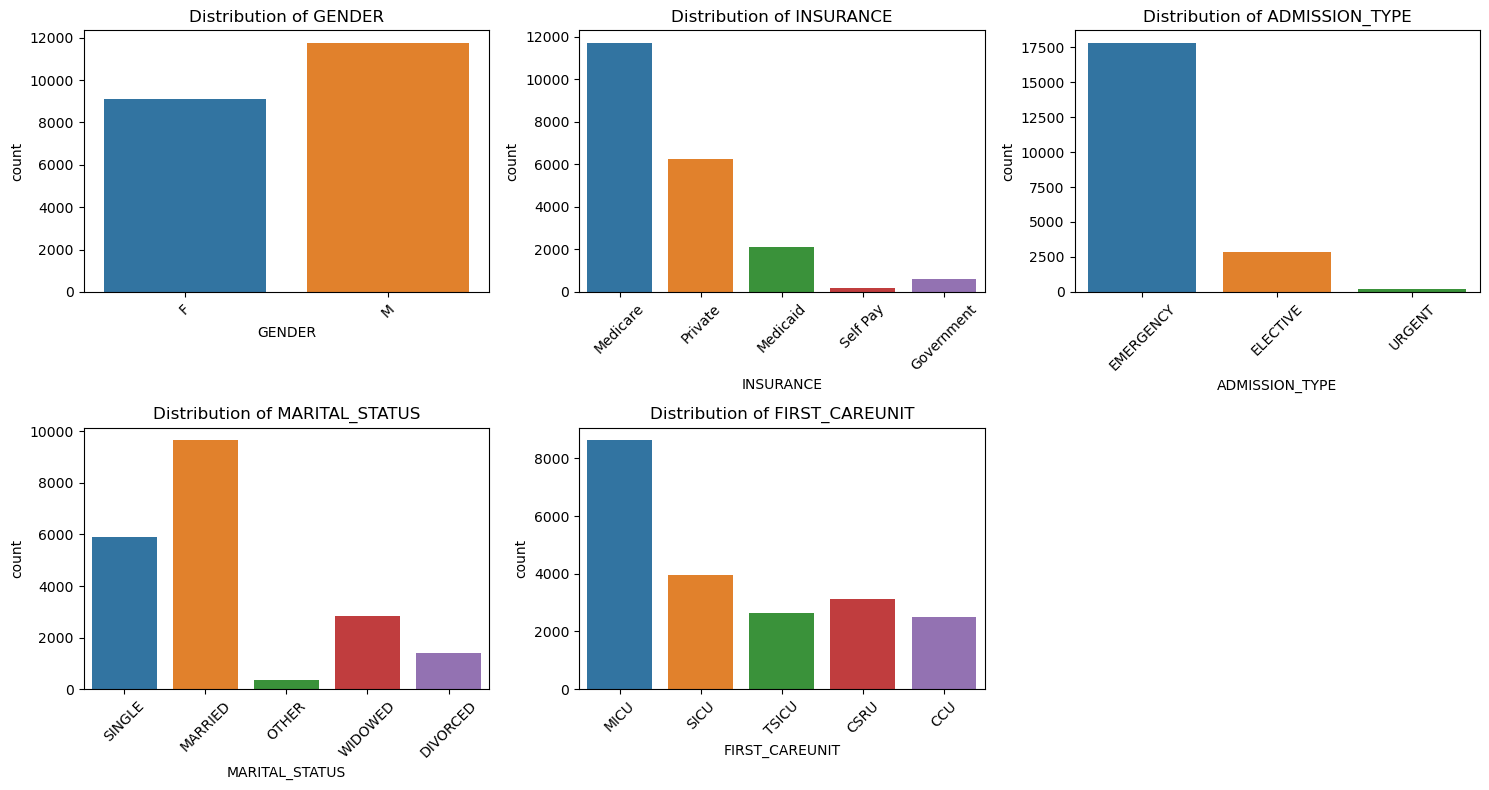

In [30]:
low_cardinality_categorical_names = ['GENDER', 'INSURANCE', 'ADMISSION_TYPE', 'MARITAL_STATUS', 'FIRST_CAREUNIT']

fcols = 3
frows = (len(low_cardinality_categorical_names) + fcols - 1) // fcols
plt.figure(figsize=(15, 4 * frows))

for i, col in enumerate(low_cardinality_categorical_names):
    plt.subplot(frows, fcols, i + 1)
    sns.countplot(data=X_train, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Handle missing data

Missing data will be handled differently depending on the type of feature: low cardinality categorical features, high cardinality categorical features and numerical features.

### Low cardinality categorical features

The first step is to check the null values per feature for both the X_train and X_test:

In [31]:
X_train_low_cardinality = X_train[low_cardinality_categorical_names]
X_train_low_cardinality.isnull().sum()

GENDER              0
INSURANCE           0
ADMISSION_TYPE      0
MARITAL_STATUS    722
FIRST_CAREUNIT      0
dtype: int64

In [32]:
X_test_low_cardinality = X_test[low_cardinality_categorical_names]
X_test_low_cardinality.isnull().sum()

GENDER              0
INSURANCE           0
ADMISSION_TYPE      0
MARITAL_STATUS    180
FIRST_CAREUNIT      0
dtype: int64

The previous output indicates that the only low cardinality categorical feature with missing data corresponds to *MARITAL_STATUS*. To handle missing data from this feature, the *SimpleImputer* will be used to replace missing values by the most frequent value of this column. To check that this step has been done correctly, we can see that there is no missing data in the low cardinality categorical features from both datasets after the imputation.

In [33]:
imp_frequent = SimpleImputer(missing_values = np.nan, strategy= 'most_frequent')

imp_frequent.fit(X_train_low_cardinality)

X_train_categorical_transform = pd.DataFrame(imp_frequent.transform(X_train_low_cardinality), columns = low_cardinality_categorical_names)
X_test_categorical_transform = pd.DataFrame(imp_frequent.transform(X_test_low_cardinality), columns = low_cardinality_categorical_names)

X_train[low_cardinality_categorical_names] = X_train_categorical_transform
X_test[low_cardinality_categorical_names] = X_test_categorical_transform

print("Missing data in low cardinality categorical features from X_train: ", X_train[low_cardinality_categorical_names].isnull().sum().sum())
print("Missing data in low cardinality categorical features from X_test: ", X_test[low_cardinality_categorical_names].isnull().sum().sum())

X_train[low_cardinality_categorical_names].head()

Missing data in low cardinality categorical features from X_train:  0
Missing data in low cardinality categorical features from X_test:  0


,GENDER,INSURANCE,ADMISSION_TYPE,MARITAL_STATUS,FIRST_CAREUNIT
0,F,Medicare,EMERGENCY,SINGLE,MICU
1,F,Private,EMERGENCY,MARRIED,MICU
2,F,Medicare,EMERGENCY,OTHER,MICU
3,F,Medicare,ELECTIVE,WIDOWED,SICU
4,F,Medicare,EMERGENCY,WIDOWED,TSICU


### High cardinality categorical features

The first step is to check the null values per feature for both the X_train and X_test. Since it was created a missing class for the missing data from the secondary codes, there aren't null values present in the high cardinality categorical features.

In [34]:
high_cardinality_categorical_names = ['ICD9_diagnosis', 'DIAGNOSIS', 'ICD9_CODE_2', 'ICD9_CODE_3', 'ICD9_CODE_4', 'ICD9_CODE_5', 'ICD9_CODE_6', 'ICD9_CODE_7', 'ICD9_CODE_8', 'ICD9_CODE_9', 'ICD9_CODE_10', 'ICD9_CODE_11', 'ICD9_CODE_12']

In [35]:
X_train_high_cardinality = X_train[high_cardinality_categorical_names]
X_train_high_cardinality.isnull().sum()

ICD9_diagnosis    0
DIAGNOSIS         0
ICD9_CODE_2       0
ICD9_CODE_3       0
ICD9_CODE_4       0
ICD9_CODE_5       0
ICD9_CODE_6       0
ICD9_CODE_7       0
ICD9_CODE_8       0
ICD9_CODE_9       0
ICD9_CODE_10      0
ICD9_CODE_11      0
ICD9_CODE_12      0
dtype: int64

In [36]:
X_test_high_cardinality = X_test[high_cardinality_categorical_names]
X_test_high_cardinality.isnull().sum()

ICD9_diagnosis    0
DIAGNOSIS         0
ICD9_CODE_2       0
ICD9_CODE_3       0
ICD9_CODE_4       0
ICD9_CODE_5       0
ICD9_CODE_6       0
ICD9_CODE_7       0
ICD9_CODE_8       0
ICD9_CODE_9       0
ICD9_CODE_10      0
ICD9_CODE_11      0
ICD9_CODE_12      0
dtype: int64

### Numerical features

As in the previous cases, let's first check the missing data per numerical feature in both X_train and X_test. All numerical features has missing data except for the variable *AGE*.

In [37]:
X_train_numerical_columns = X_train[numerical_features_names]
X_train_numerical_columns.isnull().sum().sort_values(ascending=False)

TempC_Min         2497
TempC_Mean        2497
TempC_Max         2497
DiasBP_Min        2209
DiasBP_Max        2209
DiasBP_Mean       2209
SysBP_Min         2208
SysBP_Max         2208
SysBP_Mean        2208
SpO2_Mean         2203
SpO2_Max          2203
SpO2_Min          2203
RespRate_Min      2189
RespRate_Max      2189
RespRate_Mean     2189
HeartRate_Min     2187
HeartRate_Max     2187
HeartRate_Mean    2187
MeanBP_Mean       2186
MeanBP_Max        2186
MeanBP_Min        2186
Glucose_Min        253
Glucose_Max        253
Glucose_Mean       253
AGE                  0
dtype: int64

In [38]:
X_test_numerical_columns = X_test[numerical_features_names]
X_test_numerical_columns.isnull().sum().sort_values(ascending=False)

TempC_Mean        638
TempC_Max         638
TempC_Min         638
DiasBP_Min        552
DiasBP_Max        552
DiasBP_Mean       552
SpO2_Max          551
SpO2_Mean         551
SysBP_Min         551
SysBP_Max         551
SysBP_Mean        551
SpO2_Min          551
MeanBP_Min        547
MeanBP_Mean       547
MeanBP_Max        547
RespRate_Max      546
RespRate_Mean     546
RespRate_Min      546
HeartRate_Min     545
HeartRate_Max     545
HeartRate_Mean    545
Glucose_Min        58
Glucose_Max        58
Glucose_Mean       58
AGE                 0
dtype: int64

The first step to deal with missing data from numerical features will consists on removing columns with a considerable high proportion of missing data. In this case it is established a percentage of 20% as the percentage of non-null answers required to keep a column. As can be seen, the dimensions before and after computing this step are the same, therefore it has not removed any column.

In [39]:
initial_columns = X_train_numerical_columns

print(X_train.shape)
X_train = X_train.dropna(axis=1, thresh=round(0.2 * len(X_train.index)))
print(X_train.shape)

dropped_columns = list(set(initial_columns) - set(X_train.columns))
X_test = X_test.drop(columns=dropped_columns)

(20885, 43)
(20885, 43)


The missing data from the vitals of the patient (when entering the ICU) can be imputed by the mean. A possible consideration could be to impute group by gender, therefore using the mean of the corresponding gender to impute the vitals. This option was disregarded since the means of the vitals do not vary much between females and males.

In [40]:
X_train[["HeartRate_Mean", "SysBP_Mean", "DiasBP_Mean", "MeanBP_Mean", "RespRate_Mean", "TempC_Mean", "SpO2_Mean", "Glucose_Mean", "GENDER"]].groupby("GENDER").mean()

,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean
GENDER,,,,,,,,
F,85.891303,119.006763,61.143236,76.745886,19.133123,36.734728,96.908439,139.493072
M,84.623638,119.253876,63.582002,78.285535,18.870576,36.765123,96.834014,138.362478


Since it seems not reasonable to use stratified average statistics to impute the vitals, it will be proceed with the *KNNImputer* to deal with missing data using k-Nearest Neighbors. Therefore, the missing data from the vitals will be imputed using the mean value from n_neighbors nearest neighbors found in the training dataset. The parameter *weights* is set to *'distance'* to weight points by the inverse of their distance and *n_neighbors* is set to 5. To check that this step has been done correctly, we can see that there is no missing data in the numerical features from both datasets after the imputation.

In [41]:
imp_knn = KNNImputer(n_neighbors= 5, weights = 'distance')

imp_knn.fit(X_train[numerical_features_names])

X_train[numerical_features_names] = pd.DataFrame(imp_knn.transform(X_train[numerical_features_names]), columns = numerical_features_names)
X_test[numerical_features_names] = pd.DataFrame(imp_knn.transform(X_test[numerical_features_names]), columns = numerical_features_names)

print("Missing data in numerical features from X_train: ", X_train[numerical_features_names].isnull().sum().sum())
print("Missing data in numerical features from X_test: ", X_test[numerical_features_names].isnull().sum().sum())

X_train[numerical_features_names].head()

Missing data in numerical features from X_train:  0
Missing data in numerical features from X_test:  0


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,AGE
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,...,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,69.0
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,...,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,42.0
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,...,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,68.0
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,...,36.333333,39.500000,37.833333,78.0,100.0,95.085714,108.0,139.0,125.000000,74.0
4,56.0,101.4,78.408813,111.8,158.4,136.330834,45.4,81.2,61.726907,60.4,...,35.933333,36.988889,36.469444,94.0,100.0,98.144175,97.0,137.0,113.000000,79.0


## Check skewness

The skewness is checked for the numerical features. The feature is considered slightly skewed if the skewness is between -1 and -0.5 (negative skewed) or between 0.5 and 1 (positive skewed). The feature is considered extremely skewed if the skewness is lower than -1 (negative skewed) or greater than 1 (positive skewed). 

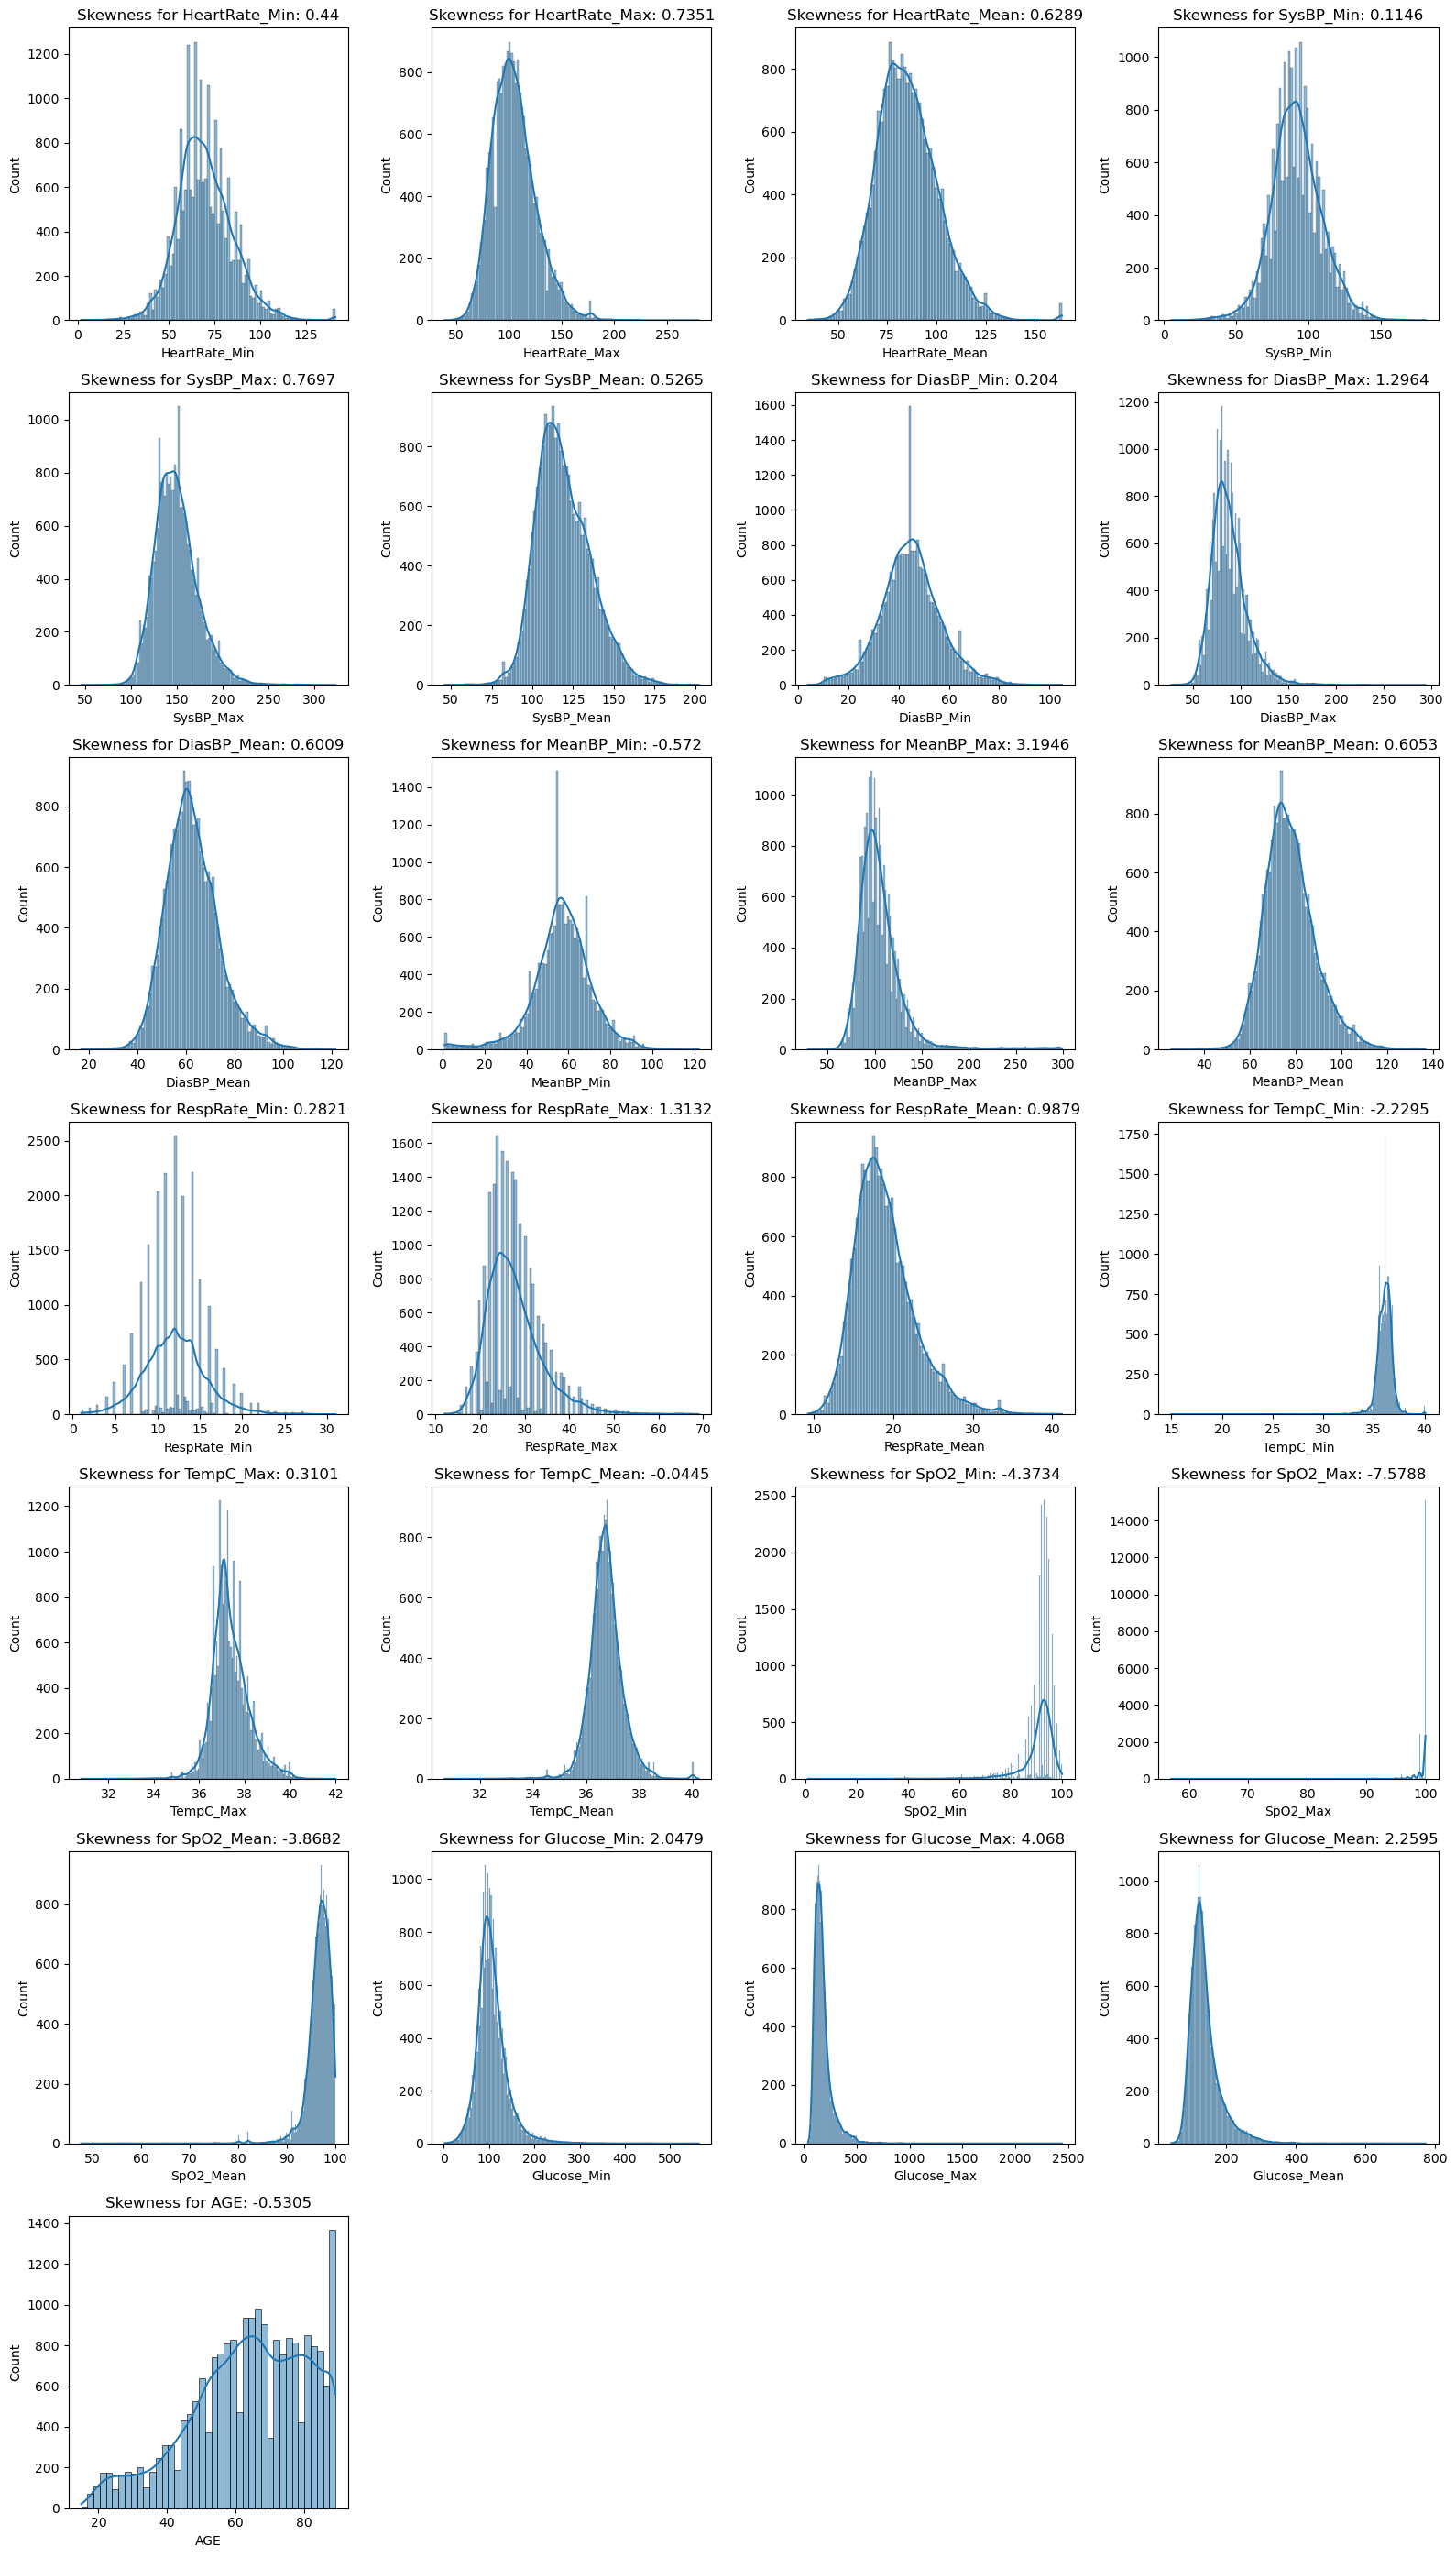

In [42]:
skewness_results = {}
num_features = len(numerical_features_names)
num_plots_per_row = 4
num_rows = (num_features + num_plots_per_row - 1) // num_plots_per_row

# Create a figure and an array of subplots
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(16, 4 * num_rows))

# Loop through each numerical feature
for i, col in enumerate(numerical_features_names):
    col_name = col
    col_skew = skew(X_train[col])
    col_skew_rounded = round(col_skew, 4)
    skewness_results[col_name] = col_skew_rounded
    row_idx = i // num_plots_per_row
    col_idx = i % num_plots_per_row
    
    # Plot a histogram in the current subplot
    sns.histplot(X_train[col], kde=True, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'Skewness for {col_name}: {col_skew_rounded}')
    
# Remove empty subplots
for i in range(num_features, num_rows * num_plots_per_row):
    row_idx = i // num_plots_per_row
    col_idx = i % num_plots_per_row
    fig.delaxes(axes[row_idx, col_idx])

# Adjust layout spacing
plt.tight_layout()

# Show all the plots
plt.show()

A log transformation is applied to handle extremely right-skewed features. Applying this transformtaion is useful for the skewed data since the distribution resembles more a normal. It is also useful to decrease the effect of outliers, thus obtaining a more robust model. As shown in the output, the log transformed numerical features log transformed correspond to *'DiasBP_Max'*, *'MeanBP_Max'*, *'RespRate_Max'*, *'Glucose_Min'*, *'Glucose_Max'* and *'Glucose_Mean'*.

In [43]:
variables_to_transform = []

for col in numerical_features_names:
    col_skew = skew(X_train[col])
    if col_skew > 1:
        variables_to_transform.append(col)

for col in variables_to_transform:
    X_train[col] = np.log(X_train[col])
    X_test[col] = np.log(X_test[col])

print("Numerical features log transformed:", variables_to_transform)

Numerical features log transformed: ['DiasBP_Max', 'MeanBP_Max', 'RespRate_Max', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean']


## Correlation among numeric features

The correlation among numeric features is computed since highly correlated features do not bring a considerable additional information, thus leading to collinearity issues:

In [44]:
correlation_matrix = X_train[numerical_features_names].corr()
correlation_matrix

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,AGE
HeartRate_Min,1.000000,0.539109,0.833334,0.024782,-0.107395,-0.071843,0.156057,0.069032,0.178201,0.090885,...,0.221588,0.253076,0.289814,0.090110,-0.125829,-0.007594,0.009696,0.024937,0.025686,-0.192903
HeartRate_Max,0.539109,1.000000,0.822140,-0.164527,0.032372,-0.097017,0.034811,0.188357,0.165675,-0.060822,...,0.122541,0.321080,0.270131,-0.129949,-0.024930,-0.076908,0.006419,0.065330,0.054895,-0.160964
HeartRate_Mean,0.833334,0.822140,1.000000,-0.102187,-0.056332,-0.111641,0.099236,0.131397,0.192384,0.002029,...,0.194756,0.320630,0.319384,-0.090033,-0.106123,-0.107416,0.010782,0.058930,0.054254,-0.197397
SysBP_Min,0.024782,-0.164527,-0.102187,1.000000,0.333864,0.754180,0.600448,0.187451,0.505814,0.691684,...,0.160949,-0.049451,0.059739,0.186627,-0.035935,0.050209,0.110392,-0.050597,0.016342,-0.147721
SysBP_Max,-0.107395,0.032372,-0.056332,0.333864,1.000000,0.748520,0.148058,0.524376,0.355625,0.206592,...,-0.000474,0.109269,0.076030,-0.003452,0.102935,0.067369,0.033090,0.119976,0.112280,0.061200
SysBP_Mean,-0.071843,-0.097017,-0.111641,0.754180,0.748520,1.000000,0.437285,0.408686,0.553888,0.528060,...,0.092433,0.016515,0.068248,0.097865,0.045154,0.063481,0.097887,0.053867,0.092806,-0.033793
DiasBP_Min,0.156057,0.034811,0.099236,0.600448,0.148058,0.437285,1.000000,0.269847,0.759434,0.762693,...,0.136270,-0.027663,0.061551,0.142232,-0.047699,0.034014,0.068247,-0.080574,-0.029893,-0.339749
DiasBP_Max,0.069032,0.188357,0.131397,0.187451,0.524376,0.408686,0.269847,1.000000,0.616865,0.202837,...,0.022386,0.052055,0.039405,-0.018099,0.024745,-0.002082,0.051871,0.010125,0.033092,-0.127944
DiasBP_Mean,0.178201,0.165675,0.192384,0.505814,0.355625,0.553888,0.759434,0.616865,1.000000,0.600960,...,0.100583,-0.007149,0.049215,0.078036,-0.033654,0.005693,0.083636,-0.055143,-0.002003,-0.392106
MeanBP_Min,0.090885,-0.060822,0.002029,0.691684,0.206592,0.528060,0.762693,0.202837,0.600960,1.000000,...,0.127860,-0.040373,0.052061,0.164612,-0.029417,0.048177,0.077817,-0.071209,-0.017303,-0.235563


Some sources set a Pearson's correlation coefficient of 0.80 as the threshold to consider two variables highly correlated. Therefore, the following output aims to find pairs of features with correlations higher than the threshold.

In [45]:
threshold = 0.80

correlation_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            correlation = correlation_matrix.iloc[i, j]
            correlation_pairs.append((feature1, feature2, correlation))

for feature1, feature2, correlation in correlation_pairs:
    print(f"Correlation between {feature1} and {feature2}: {correlation:.2f}")

Correlation between HeartRate_Min and HeartRate_Mean: 0.83
Correlation between HeartRate_Max and HeartRate_Mean: 0.82
Correlation between DiasBP_Mean and MeanBP_Mean: 0.90
Correlation between TempC_Max and TempC_Mean: 0.85
Correlation between Glucose_Max and Glucose_Mean: 0.88


 To avoid collinearity issues, the numerical variables *HeartRate_Mean*, *MeanBP_Mean*, *TempC_Mean* and *Glucose_Mean* are dropped from both the training and testing set:

In [46]:
X_train = X_train.drop(['HeartRate_Mean', 'MeanBP_Mean', 'TempC_Mean', 'Glucose_Mean'], axis = 1)
X_test = X_test.drop(['HeartRate_Mean', 'MeanBP_Mean', 'TempC_Mean', 'Glucose_Mean'], axis = 1)

In [47]:
X_train.head()

,HeartRate_Min,HeartRate_Max,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,...,ICD9_CODE_4,ICD9_CODE_5,ICD9_CODE_6,ICD9_CODE_7,ICD9_CODE_8,ICD9_CODE_9,ICD9_CODE_10,ICD9_CODE_11,ICD9_CODE_12,AGE
0,89.0,145.0,74.0,127.0,106.586957,42.0,4.499810,61.173913,59.0,4.543295,...,42831,42732,2851,53550,79092,4280,42731,42789,49320,69.0
1,63.0,110.0,89.0,121.0,106.733333,49.0,4.304065,64.733333,58.0,4.430817,...,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,MISSING_DIAGNOSIS,42.0
2,81.0,98.0,88.0,138.0,112.785714,45.0,4.204693,56.821429,64.0,4.477337,...,5789,5121,5119,56889,E8788,3310,29410,40390,25002,68.0
3,76.0,128.0,84.0,135.0,106.972973,30.0,4.488636,41.864865,48.0,4.543295,...,4280,53081,73300,2720,4019,2440,30000,311,V1082,74.0
4,56.0,101.4,111.8,158.4,136.330834,45.4,4.396915,61.726907,60.4,4.572647,...,5180,9341,99859,6822,9971,42732,42832,E8788,42731,79.0


## Encode categorical data

### Low cardinality categorical features

The low cardinality categorical variables will be encoded using one-hot encoding to transform categorical variables into dummies. The parameter *drop_first = True* is used to get k-1 dummies out of k categorical levels by removing the first level.

In [48]:
columns_to_encode = ['GENDER', 'INSURANCE', 'ADMISSION_TYPE', 'MARITAL_STATUS', 'FIRST_CAREUNIT']

for col in columns_to_encode:
    X_train = pd.get_dummies(X_train, prefix=[col], columns=[col], drop_first=True)
    X_test = pd.get_dummies(X_test, prefix=[col], columns=[col], drop_first=True)

X_test.head()

,HeartRate_Min,HeartRate_Max,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,...,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,MARITAL_STATUS_MARRIED,MARITAL_STATUS_OTHER,MARITAL_STATUS_SINGLE,MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
0,58.0,90.0,77.0,153.0,98.490909,40.0,4.343805,52.018182,53.0,4.624973,...,0,0,1,0,0,0,1,0,0,0
1,91.0,145.0,73.0,143.0,101.210526,42.0,4.454347,65.578947,50.0,5.620401,...,1,0,1,0,0,0,0,1,0,0
2,106.0,132.0,93.0,137.0,116.222222,51.0,4.330733,66.703704,60.0,4.465908,...,0,0,1,0,0,0,0,1,0,0
3,72.0,105.0,72.0,168.0,126.981818,39.0,4.595120,62.854545,46.0,4.700480,...,1,0,0,0,0,1,0,0,0,0
4,85.0,124.0,86.0,144.0,110.666667,52.0,4.890349,72.833333,66.0,4.905275,...,1,0,0,0,1,0,0,1,0,0


### High cardinality categorical features

For high cardinality categorical variables target encoder is used with *TargetEncoder* from the *Category Encoders* package. According to the documentation from *TargetEncoder*, for the case of a categorical target (in our case 'HOSPITAL_EXPIRE_FLAG'), features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data (Source: https://contrib.scikit-learn.org/category_encoders/targetencoder.html). *Smoothing* corresponds to the smoothing effect to balance categorical average versus the prior. This parameter is set to 10 because if the value is increased a lot then it contributes to overfitting and if it is more closest to 0 (since it should be strictly larger than 0) then the model looses predictive accuracy. The target encoder is fitted with training data and applied to both training and testing dataset. 

In [49]:
columns = ['ICD9_diagnosis', 'DIAGNOSIS', 'ICD9_CODE_2', 'ICD9_CODE_3', 'ICD9_CODE_4', 'ICD9_CODE_5', 'ICD9_CODE_6', 'ICD9_CODE_7', 'ICD9_CODE_8', 'ICD9_CODE_9', 'ICD9_CODE_10', 'ICD9_CODE_11', 'ICD9_CODE_12']

for col in columns:
    te = TargetEncoder(smoothing = 10)
    te.fit(X = X_train[col], y = y_train)
    values_train = te.transform(X_train[col])
    values_test = te.transform(X_test[col])
    X_train[col] = values_train
    X_test[col] = values_test

X_train[columns].head()

,ICD9_diagnosis,DIAGNOSIS,ICD9_CODE_2,ICD9_CODE_3,ICD9_CODE_4,ICD9_CODE_5,ICD9_CODE_6,ICD9_CODE_7,ICD9_CODE_8,ICD9_CODE_9,ICD9_CODE_10,ICD9_CODE_11,ICD9_CODE_12
0,0.097436,0.071429,0.275786,0.211516,0.119300,0.091979,0.086758,0.084240,0.094951,0.134831,0.159601,0.101135,0.092188
1,0.097673,0.096354,0.097673,0.086291,0.029345,0.037246,0.043683,0.049776,0.049107,0.053217,0.055788,0.059125,0.063490
2,0.145399,0.089189,0.222613,0.305085,0.161361,0.116586,0.166666,0.167280,0.009339,0.136247,0.180643,0.174699,0.123116
3,0.075025,0.093420,0.092188,0.097673,0.047264,0.060606,0.051120,0.030304,0.081346,0.086291,0.034083,0.077465,0.077471
4,0.025200,0.146259,0.145390,0.090070,0.055866,0.084240,0.129180,0.081141,0.145504,0.126133,0.120229,0.101905,0.170492


## Transform metadata columns

The addition of secondary codes increase the complexity of the model, therefore it seems reasonable to convert those columns into summary statistics and drop the initial columns from metadata. For example, including the mean can be useful to capture the central tendency of comorbidities for each patient.

In [50]:
columns_to_convert_statistics = ['ICD9_CODE_2', 'ICD9_CODE_3', 'ICD9_CODE_4', 'ICD9_CODE_5', 'ICD9_CODE_6', 'ICD9_CODE_7', 'ICD9_CODE_8', 'ICD9_CODE_9', 'ICD9_CODE_10', 'ICD9_CODE_11', 'ICD9_CODE_12']
    
X_train['METADATA_MEAN'] = X_train[columns_to_convert_statistics].mean(axis=1)
X_train['METADATA_MAX'] = X_train[columns_to_convert_statistics].max(axis=1)

X_train = X_train.drop(columns_to_convert_statistics, axis=1)

X_test['METADATA_MEAN'] = X_test[columns_to_convert_statistics].mean(axis=1)
X_test['METADATA_MAX'] = X_test[columns_to_convert_statistics].max(axis=1)

X_test = X_test.drop(columns_to_convert_statistics, axis=1)

It can be seen that the dimensions from both the training and testing dataset had been reduced by 9 columns.

In [51]:
X_train.head()

,HeartRate_Min,HeartRate_Max,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,...,MARITAL_STATUS_MARRIED,MARITAL_STATUS_OTHER,MARITAL_STATUS_SINGLE,MARITAL_STATUS_WIDOWED,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU,METADATA_MEAN,METADATA_MAX
0,89.0,145.0,74.0,127.0,106.586957,42.0,4.499810,61.173913,59.0,4.543295,...,0,0,1,0,0,1,0,0,0.132026,0.275786
1,63.0,110.0,89.0,121.0,106.733333,49.0,4.304065,64.733333,58.0,4.430817,...,1,0,0,0,0,1,0,0,0.056795,0.097673
2,81.0,98.0,88.0,138.0,112.785714,45.0,4.204693,56.821429,64.0,4.477337,...,0,1,0,0,0,1,0,0,0.160330,0.305085
3,76.0,128.0,84.0,135.0,106.972973,30.0,4.488636,41.864865,48.0,4.543295,...,0,0,0,1,0,0,1,0,0.066892,0.097673
4,56.0,101.4,111.8,158.4,136.330834,45.4,4.396915,61.726907,60.4,4.572647,...,0,0,0,1,0,0,0,1,0.113650,0.170492


## Feature standardization

Features are scaled using *StandardScaler*. The parameters *with_mean* and *with_std* are set to *True* which implies that data is centered before scaling and it scale the data to unit variance. The scaler is fitted with the training dataset and then applied to both training and testing dataset.

In [52]:
scaler = preprocessing.StandardScaler(with_mean = True, with_std = True)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train) 
X_test = pd.DataFrame(X_test)

# KNN model

First, it is created an instance of a K-nearest neighbors classifier (KNeighborsClassifier) and set the *algorithm* parameter to *'brute'* which involves the brute-force computation of distances between all pairs of observations in the dataset. Performing grid search over *algorithm* is used to make the algorithm faster not to improve performance, that is why it is not included in the GridSearch.

The hyperparameter optimization is done before fitting the model. The parameters tuned in the GridSearch corresponds to:
- *n_neighbors* which is the number of neighbors. This parameter is grid search over a range from 50 to 350 with increases of 50 since a low number of neighbors increases variance but a high number increases bias.
- *weights* which refers to the weight function used in prediction. While *uniform* distance uses uniform weights, *distance* weights observations by the inverse of the distance.
- *metric* which corresponds to the distance measure.

Then the SVM model is fitted with the *X_train* and *y_train*.

In [53]:
MyKNN = KNeighborsClassifier(algorithm =  'brute')

grid_values = {'n_neighbors':[50, 100, 150, 200, 250, 300, 350], 'weights':['uniform','distance'], 'metric': ['manhattan', 'minkowski']}

grid_knn_acc = GridSearchCV(MyKNN, param_grid = grid_values, scoring = 'roc_auc', n_jobs = -1, cv = 20) # CV defines the number of folds 

grid_knn_acc.fit(X_train, y_train)

GridSearchCV(cv=20, estimator=KNeighborsClassifier(algorithm='brute'),
             n_jobs=-1,
             param_grid={'metric': ['manhattan', 'minkowski'],
                         'n_neighbors': [50, 100, 150, 200, 250, 300, 350],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

## Optimal parameters from the grid

The optimal parameters from the grid correspond to 350 neighbors, the optimal *weights* is *'distance'* and the *metric* is *'manhattan'*. The resulting best score equals 0.93683. 

best parameters: {'metric': 'manhattan', 'n_neighbors': 350, 'weights': 'distance'}
best score:      0.93683 (+/-0.01322)


,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
13,manhattan,350,distance,"{'metric': 'manhattan', 'n_neighbors': 350, 'weights': 'distance'}",0.929369,0.934535,0.935760,0.929269,0.933145,0.942319,...,0.942153,0.929337,0.943186,0.936907,0.901175,0.941895,0.951585,0.936831,0.013219,1
9,manhattan,250,distance,"{'metric': 'manhattan', 'n_neighbors': 250, 'weights': 'distance'}",0.923505,0.935604,0.935997,0.928154,0.934681,0.941701,...,0.942098,0.929697,0.942458,0.936151,0.904333,0.943877,0.952092,0.936718,0.012966,2
11,manhattan,300,distance,"{'metric': 'manhattan', 'n_neighbors': 300, 'weights': 'distance'}",0.926238,0.935741,0.934731,0.928963,0.933840,0.941268,...,0.942006,0.928784,0.942983,0.936741,0.903272,0.942126,0.951336,0.936534,0.012865,3
7,manhattan,200,distance,"{'metric': 'manhattan', 'n_neighbors': 200, 'weights': 'distance'}",0.921526,0.934461,0.935563,0.922380,0.933474,0.942218,...,0.941047,0.930047,0.940770,0.936474,0.903286,0.944329,0.951641,0.936280,0.013533,4
12,manhattan,350,uniform,"{'metric': 'manhattan', 'n_neighbors': 350, 'weights': 'uniform'}",0.929571,0.934023,0.934379,0.929356,0.932363,0.942010,...,0.941153,0.928466,0.942633,0.936607,0.900460,0.941176,0.951327,0.936195,0.013368,5
8,manhattan,250,uniform,"{'metric': 'manhattan', 'n_neighbors': 250, 'weights': 'uniform'}",0.922741,0.934845,0.933831,0.928195,0.934119,0.941346,...,0.941033,0.928766,0.941711,0.935464,0.903839,0.943227,0.951761,0.935973,0.013116,6
10,manhattan,300,uniform,"{'metric': 'manhattan', 'n_neighbors': 300, 'weights': 'uniform'}",0.926033,0.935092,0.932596,0.929017,0.933076,0.940673,...,0.940950,0.928120,0.942388,0.936400,0.903139,0.941536,0.951041,0.935847,0.012962,7
5,manhattan,150,distance,"{'metric': 'manhattan', 'n_neighbors': 150, 'weights': 'distance'}",0.922257,0.937103,0.937506,0.922028,0.930622,0.936142,...,0.941595,0.930324,0.942430,0.936317,0.903724,0.943389,0.949354,0.935770,0.013300,8
6,manhattan,200,uniform,"{'metric': 'manhattan', 'n_neighbors': 200, 'weights': 'uniform'}",0.920406,0.933332,0.933556,0.922353,0.932660,0.941914,...,0.939751,0.928946,0.939821,0.935801,0.903083,0.943748,0.951452,0.935481,0.013685,9
4,manhattan,150,uniform,"{'metric': 'manhattan', 'n_neighbors': 150, 'weights': 'uniform'}",0.920927,0.936281,0.935673,0.921439,0.929520,0.934667,...,0.940461,0.929904,0.941388,0.935920,0.902309,0.942356,0.949110,0.934857,0.013643,10


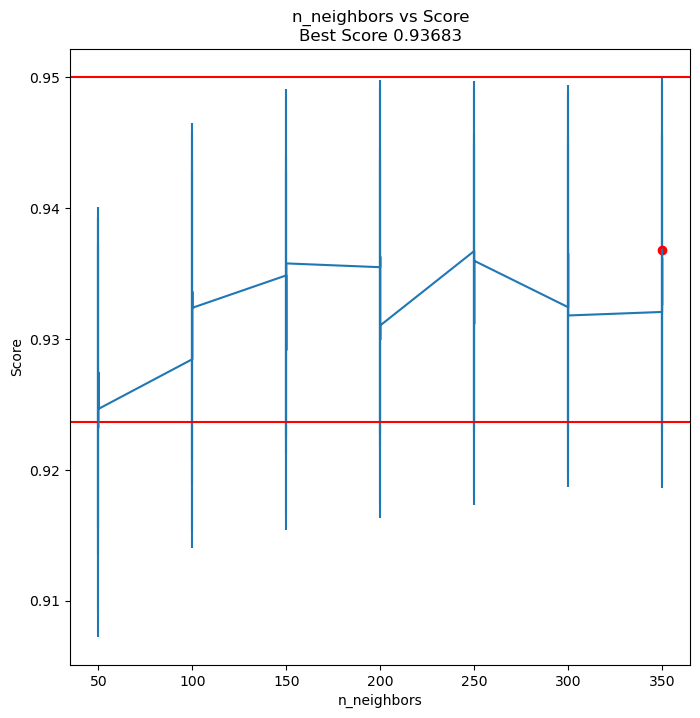

Best k parameter : 350
Best weights parameter : distance
Best metric parameter : manhattan


In [54]:
GridSearch_table_plot(grid_knn_acc, "n_neighbors", negative=False, display_all_params=False)

print('Best k parameter : '+ str(grid_knn_acc.best_estimator_.n_neighbors))
print('Best weights parameter : '+ str(grid_knn_acc.best_estimator_.weights))
print('Best metric parameter : '+ str(grid_knn_acc.best_estimator_.metric))

## Out-of-sample predictions

The out-of-sample predictions uses the data from the *X_test* which has not been used to train the model.

In [61]:
knn_outsample_pred_prob = grid_knn_acc.predict_proba(X_test)

## In-sample predictions

The in-sample predictions uses the data from the *X_train* which has been used to train the model.

In [62]:
knn_insample_pred_prob = grid_knn_acc.predict_proba(X_train)

print("AUC: ", roc_auc_score(y_train, knn_insample_pred_prob[:, 1]))

AUC:  1.0


The ROC AUC score obtained from the in-sample prediction corresponds to 1. Since the score is 1, it suggests that the model perfectly distinguish between patients who die or survive. Through the following confusion matrix it can be seen that all the observations from the training dataset are correctly classified, thus obtaining a False Positive Rate and False Negative Rate of 0. Said result can also suggest overfitting, which may be addressed as a future line to improve the project. However, the optimal parameters have been selected using cross-validation, which mitigates the effect of overfitting, that is why the best score equals 0.93683.

Confusion matrix


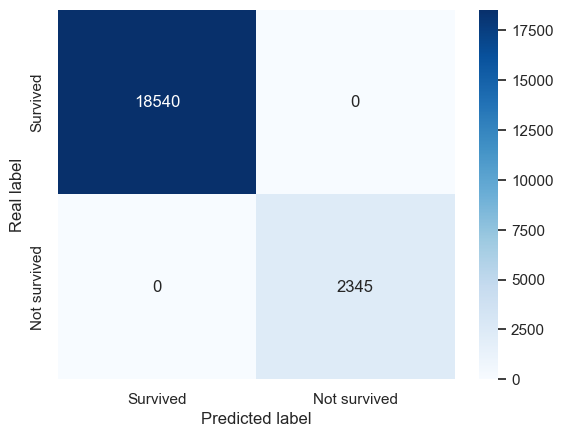

In [63]:
print("Confusion matrix")
cm=confusion_matrix(y_train,knn_insample_pred_prob[:,1])
plot_confusion_matrix(cm, ['Survived','Not survived'])

# Output predictions file

The following code produce a csv file with the output predictions to submit them to Kaggle:

In [58]:
test_predictions_submit_knn = pd.DataFrame({"icustay_id": data_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": knn_outsample_pred_prob[:, 1]})
test_predictions_submit_knn.to_csv("test_predictions_submit_knn.csv", index = False)

The file containing the output predictions has the following form:

In [59]:
test_predictions_submit_knn.head()

,icustay_id,HOSPITAL_EXPIRE_FLAG
0,208169,0.000000
1,251754,0.089282
2,242171,0.034024
3,263035,0.030682
4,279388,0.058527
